# Libraries

In [1]:
import requests

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

#import dtale 

pd.set_option('display.max_columns', None) # display all columns in DF

In [546]:
df = pd.read_csv('output_regression_org.csv', sep = '~')

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Color Palette

In [212]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [213]:
pal = sns.color_palette("Set2")
pal.as_hex()
print(pal)

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]


# Figure 1: Number of producers and avg. log price per unit

Import data

In [618]:
df = pd.read_csv('output_regression_org.csv', sep = '~')

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [619]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand-name producer' if x == 1 else 'Generic producer')

Calculating the avg. price grouped by the number of producers

In [620]:
df_temp = df_temp.groupby(['producer_type', 'running_count_generics', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp['running_count_generics'] = df_temp['running_count_generics'] + 1
df_temp['ln_price_per_unit_adj'] = np.log(df_temp['price_per_unit_adj'])

Plotting the figure

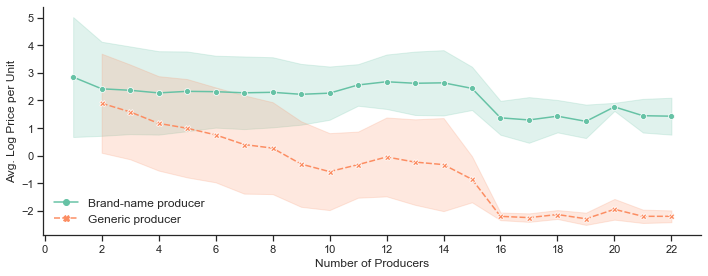

In [621]:
x = df_temp['running_count_generics'].max() # length of x-axis

fig = sns.relplot(data = df_temp, kind = 'line',
                  x = 'running_count_generics', y= 'ln_price_per_unit_adj',
                  hue = 'producer_type', style = 'producer_type', ci = 'sd', markers = True, facet_kws={'legend_out': False},
                  height = 4, aspect = 2.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

#plt.title('Price dynamics in the face of increasing competition')
plt.xlabel('Number of Producers')
plt.ylabel('Avg. Log Price per Unit')
plt.legend(loc = 'lower left', frameon = False, fontsize = 12)
plt.xticks(np.arange(0, x + 1, 2))

plt.show()
#plt.savefig('x.png', bbox_inches = 'tight')

Describing the data

In [622]:
print('Total number of drugs: ', df['unique_id'].nunique())
print('Total numober of brand-name producers: ', df['labeler_name'].nunique())
print('Total numober of generic producers: ', df['generic_name'].nunique())

Total number of drugs:  2886
Total numober of brand-name producers:  595
Total numober of generic producers:  1155


# Figure 2: Number of producers after second entrance

Import data

In [624]:
df = pd.read_csv('output_regression_org.csv', sep = '~')

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [627]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand-name producer' if x == 1 else 'Generic producer')

Removing obs. before event

In [628]:
df_temp = df_temp[df_temp['running_count_event'] >= 0]

Calculating the number of producers split between brand-name and genenic producers along with the avg. number of producers per unique drug

In [629]:
df_temp = df_temp.groupby(['running_count_event', 'producer_type'], as_index = False)[['labeler_name']].count()

df_temp = df_temp.pivot(index = 'running_count_event', columns = 'producer_type', values = ['labeler_name'])
df_temp = df_temp.droplevel(level = 1, axis = 1)
df_temp = df_temp.reset_index()
df_temp.columns = ['running_count_event','number_of_brand_name_producers','number_of_generic_producers']

df_temp['average_number_of_producers'] = df_temp['number_of_generic_producers'] / df_temp['number_of_brand_name_producers']

Plotting the figure

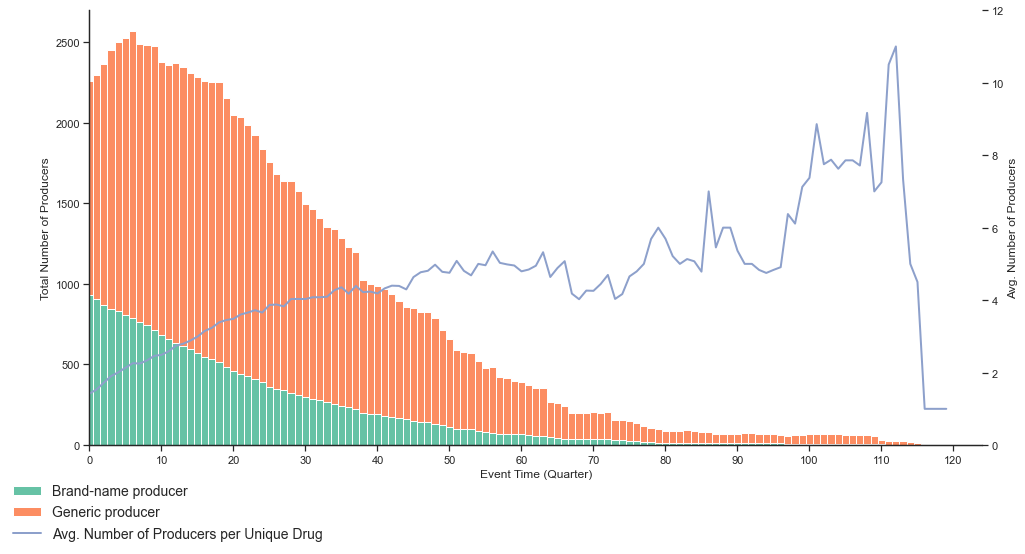

In [630]:
x = df_temp['running_count_event'].max() # length of x-axis
y = df_temp['average_number_of_producers'].max() # length of 2. y-axis

fig, ax = plt.subplots()

fig.set_figwidth(16)
fig.set_figheight(8)

set_width = 1

ax.bar(df_temp['running_count_event'], df_temp['number_of_brand_name_producers'], label = 'Brand-name producer', color = (0.4, 0.7607843137254902, 0.6470588235294118), width = set_width)
ax.bar(df_temp['running_count_event'], df_temp['number_of_generic_producers'], bottom = df_temp['number_of_brand_name_producers'], label = 'Generic producer', color = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), width = set_width)
ax.set_ylabel('Total Number of Producers')
plt.legend(bbox_to_anchor = (-0.1, -0.2), loc = 'lower left', frameon = False, fontsize = 14)
plt.xlabel('Event Time (Quarter)')

ax = plt.twinx()
ax.plot(df_temp['running_count_event'], df_temp['average_number_of_producers'], '-', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = 'Avg. Number of Producers per Unique Drug')
ax.set_ylim(0, y + 1)
ax.set_ylabel('Avg. Number of Producers')
plt.legend(bbox_to_anchor = (-0.1, -0.25), loc = 'lower left', frameon = False, fontsize = 14)

#plt.title('Number of producers from event')
plt.xticks(np.arange(0, x + 5, 10))
plt.xlim(left = 0) # white space
plt.xlim(right = x + 5) # white space

plt.show()
#plt.savefig('x.png', bbox_inches = 'tight')

# Figure 3.a: Price Dynamics before and after the event

Import data

In [643]:
df = pd.read_csv('output_regression_org.csv', sep = '~')

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [644]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand-name producer' if x == 1 else 'Generic producer')

Calculating the avg. price split between brand-name and genenic producers

In [645]:
df_temp_price = df_temp.groupby(['running_count_event', 'producer_type', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp_price['ln_price_per_unit_adj'] = np.log(df_temp_price['price_per_unit_adj'])

Calculating the total quantity split between brand-name and genenic producers along with brand-name producers' share

In [646]:
df_temp_quantity = df_temp.groupby(['running_count_event', 'producer_type'], as_index = False)['units_reimbursed'].sum()

df_temp_quantity = df_temp_quantity.pivot(index = 'running_count_event', columns = 'producer_type', values = 'units_reimbursed')
df_temp_quantity = df_temp_quantity.reset_index()
df_temp_quantity.columns = ['running_count_event', 'units_reimbursed_brand_name_producers','units_reimbursed_generic_producers']

df_temp_quantity['units_reimbursed_generic_producers'] = df_temp_quantity['units_reimbursed_generic_producers'].fillna(0)

df_temp_quantity['units_reimbursed_brand_name_producers_share'] = ((df_temp_quantity['units_reimbursed_brand_name_producers']) / (df_temp_quantity['units_reimbursed_brand_name_producers'] + df_temp_quantity['units_reimbursed_generic_producers'])) * 100

Plotting figure

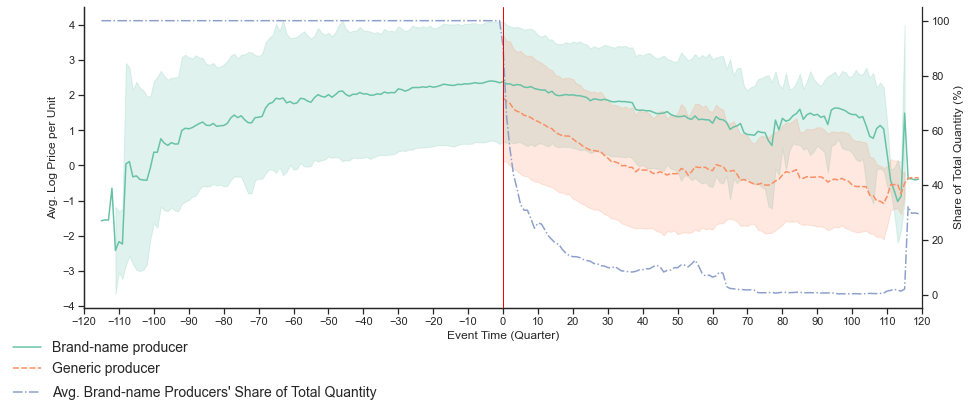

In [647]:
fig = sns.relplot(data = df_temp_price, kind = 'line', # Curves for avg. price
                  x = 'running_count_event', y= 'ln_price_per_unit_adj',
                  hue = 'producer_type', style = 'producer_type', ci = 'sd', markers = False, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)
plt.xlabel('Event Time (Quarter)')
plt.ylabel('Avg. Log Price per Unit')
plt.legend(bbox_to_anchor = (-0.1, -0.27), loc = 'lower left', frameon = False, fontsize = 14)
plt.xticks(np.arange(-115 - 5, 119 + 6, 10))
plt.xlim(left = -120) # white space
plt.xlim(right = 120) # white space

fig = plt.twinx() # Curves for total Quantity
fig.plot(df_temp_quantity['running_count_event'], df_temp_quantity['units_reimbursed_brand_name_producers_share'], '-.', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = "Avg. Brand-name Producers' Share of Total Quantity")
fig.set_ylabel('Share of Total Quantity (%)')
plt.legend(bbox_to_anchor = (-0.1, -0.35), loc = 'lower left', frameon = False, fontsize = 14)

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

plt.axvline(0, color = "red", lw = 1, ls = '-')

#plt.title('Price dynamics before and after the event')

plt.show()
#plt.savefig('x.png', bbox_inches = 'tight')

# Figure 3.b: Price Dynamics before and after the event (more producers)

Import data

In [694]:
df = pd.read_csv('output_regression_org.csv', sep = '~')

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [695]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand-name producer' if x == 1 else 'Generic producer')

Splitting genenic producers based on the timing of entrance

In [696]:
df_temp_price = df_temp

df_temp_price['col_temp'] = 3

df_temp_price['labeler_name_count'] = df_temp_price['labeler_name_count'].astype('int') 
df_temp_price['labeler_name_count'] = df_temp_price['labeler_name_count'] - 1
df_temp_price['labeler_name_count'] = np.where(df_temp_price['labeler_name_count'] > df_temp_price['col_temp'], '3+', df_temp_price['labeler_name_count'])

df_temp_price['producer_type_count'] = df_temp_price['producer_type'].astype(str) + ': ' + df_temp_price['labeler_name_count'].astype(str)

df_temp_price['producer_type_count'] = df_temp_price['producer_type_count'].replace('Brand-name producer: 0', 'Brand-name producer')

Calculating the avg. price split between brand-name and genenic producers

In [697]:
df_temp_price = df_temp_price.groupby(['running_count_event', 'producer_type_count', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp_price['ln_price_per_unit_adj'] = np.log(df_temp_price['price_per_unit_adj'])

Calculating the total quantity split between brand-name and genenic producers along with brand-name producers' share

In [698]:
df_temp_quantity = df_temp

df_temp_quantity = df_temp_quantity.groupby(['running_count_event', 'producer_type'], as_index = False)['units_reimbursed'].sum()

df_temp_quantity = df_temp_quantity.pivot(index = 'running_count_event', columns = 'producer_type', values = 'units_reimbursed')
df_temp_quantity = df_temp_quantity.reset_index()
df_temp_quantity.columns = ['running_count_event', 'units_reimbursed_brand_name_producers','units_reimbursed_generic_producers']

df_temp_quantity['units_reimbursed_generic_producers'] = df_temp_quantity['units_reimbursed_generic_producers'].fillna(0)

df_temp_quantity['units_reimbursed_brand_name_producers_share'] = ((df_temp_quantity['units_reimbursed_brand_name_producers']) / (df_temp_quantity['units_reimbursed_brand_name_producers'] + df_temp_quantity['units_reimbursed_generic_producers'])) * 100

Plotting figure

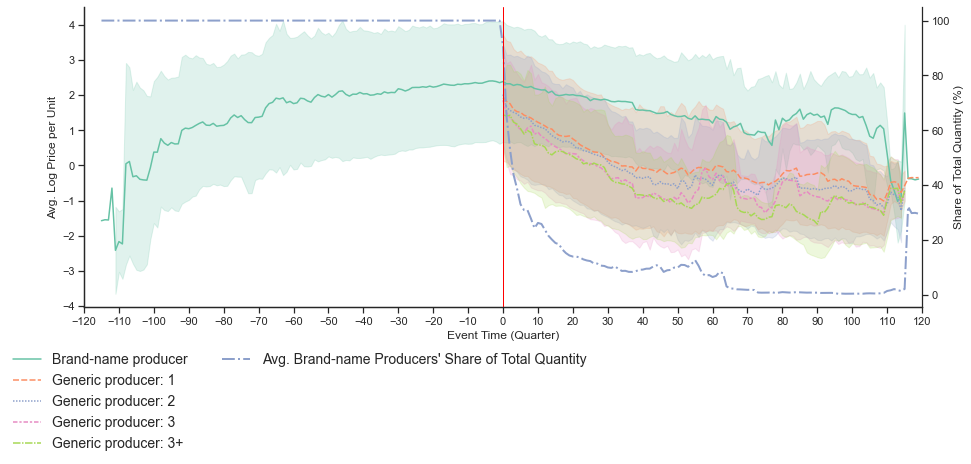

In [700]:
fig = sns.relplot(data = df_temp_price, kind = 'line', # Curves for avg. price
                  x = 'running_count_event', y= 'ln_price_per_unit_adj',
                  hue = 'producer_type_count', style = 'producer_type_count', ci = 'sd', markers = False, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)
plt.xlabel('Event Time (Quarter)')
plt.ylabel('Avg. Log Price per Unit')
plt.legend(bbox_to_anchor = (-0.1, -0.52), loc = 'lower left', frameon = False, fontsize = 14)
plt.xticks(np.arange(-115 - 5, 119 + 6, 10))
plt.xlim(left = -120) # white space
plt.xlim(right = 120) # white space

fig = plt.twinx() # Curves for total Quantity
fig.plot(df_temp_quantity['running_count_event'], df_temp_quantity['units_reimbursed_brand_name_producers_share'], '-.', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = "Avg. Brand-name Producers' Share of Total Quantity")
fig.set_ylabel('Share of Total Quantity (%)')
plt.legend(bbox_to_anchor = (0.15, -0.24), loc = 'lower left', frameon = False, fontsize = 14)

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

plt.axvline(0, color = "red", lw = 1, ls = '-')

#plt.title('Price dynamics before and after the event (more generic producers)')

plt.show()
#plt.savefig('x.png', bbox_inches = 'tight')

# Specific drug figure

In [4]:
df_figure = df.loc[df['unique_id'] == "alprazolam-tablet, extended release-oral-['.5 mg/1']"]
df_figure['date'] = pd.to_datetime(df_figure['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

In [5]:
df_figure = df_figure.groupby(['date', 'generic_name', 'labeler_name', ])['price_per_unit_adj'].mean()
df_figure = df_figure.reset_index()
df_figure['ln_price_per_unit_adj'] = np.log(df_figure['price_per_unit_adj'])

In [6]:
df_figure

,date,generic_name,labeler_name,price_per_unit_adj,ln_price_per_unit_adj


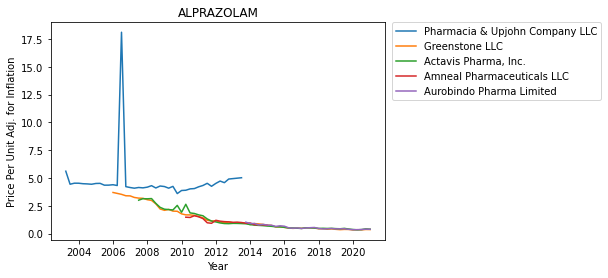

In [37]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0])
p = p.get_figure()
#p.savefig("Fig_one_drug.png",bbox_inches="tight")

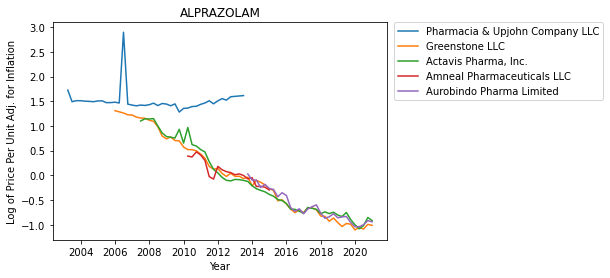

In [39]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'ln_price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Log of Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0])
p = p.get_figure()
#p.savefig("Fig_one_drug_log.png", bbox_inches="tight")